# Final Report 

#### Group Members: Ivan, Ruohan, Hiroshi, Samin

## Introduction

Employee attrition is a key issue for organizations, resulting in increased costs, lost knowledge, and disruptions in operations. Understanding and anticipating employee turnover is critical for HR management and organizational planning. Previous studies have emphasized the necessity of using data-driven methods to uncover significant factors impacting attrition, such as compensation, employment tenure, and workplace environment. This study uses a dataset of 4,653 employee records, including factors such as education level, age, gender, payment tier, and job experience, to develop a predictive model for attrition.

We will be using this dataset:

https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset 

This is a sample dataset that includes data for employees in a company, notably their qualifications, time of joining, location, salary tiers, age, gender, if they have been without assigned work, experience, and a target column of whether they have left. The data is anonymized, it is real data that has been provided by someone with access to a company's HR data, however all the staff and the company is unknown for privacy reasons. There is missing context for some of the columns, notably salary tiers, where it is not known what each tier means, although there is speculation from users of the dataset that a higher tier means more pay, it is not confirmed whether it is true or false.

### Detailed Variable Descriptions

| **Variable Name**           | **Description**                                                          | **Type**         | **Example Values**        |
|-----------------------------|---------------------------------------------------------------------------|-----------------|---------------------------|
| `Education`                 | Educational qualifications (degree, field of study, etc.)                | Categorical     | "Bachelors"        |
| `Joining Year`              | Year the employee joined the company                                     | Numerical       | 2015, 2018                |
| `City`                      | Location where the employee works                                        | Categorical     | "New Delhi", "Pune"     |
| `Payment Tier`              | Employee’s salary tier (categorization of income levels)                 | Ordinal         | 1, 2, 3                   |
| `Age`                       | Age of the employee                                                      | Numerical       | 25, 34, 42                |
| `Gender`                    | Employee’s gender identity                                               | Categorical     | "Male", "Female" |
| `Ever Benched`              | Whether the employee was temporarily without assigned work               | Binary          | "Yes", "No"               |
| `Experience in Current Domain` | Number of years the employee has worked in their current field      | Numerical       | 2, 5, 7                  |
| `Leave or Not` (Target)     | Indicates if the employee left the company (attrition)                   | Binary          | 0 (No), 1 (Yes)           |


Data Distribution and Summary Statistics:
- Education: The majority of employees have a Bachelor’s degree (3,601), followed by Master’s (873) and PhD (179) qualifications.
- Joining Year: Employees joined between 2012 and 2018, with a median joining year of 2015.
- City: The largest number of employees are from Bangalore (2,228), followed by Pune (1,268) and New Delhi (1,157).
- Payment Tier: Payment tiers are distributed as 1 (243 employees), 2 (918 employees), and 3 (3,492 employees).
- Age: The age range of employees is from 22 to 41 years, with a mean age of approximately 29.4 years.
- Gender: The dataset includes 1,875 female and 2,778 male employees.
- Ever Benched: Most employees have not been benched (4,175), while 478 have experienced benching.
- Experience in Current Domain: The experience ranges from 0 to 7 years, with a mean of approximately 2.9 years.
- Leave or Not: 1,600 employees have left the company, while 3,053 have remained.

### Research Question

The dataset's target variable, Leave or Not, indicates whether an employee has left the company, while the remaining variables serve as predictors. To analyze these relationships, the study applies Lasso regression, a machine learning technique for feature selection and regularization. Tibshirani's (1996) introduction of Lasso regression demonstrated its ability to handle high-dimensional datasets by penalizing less relevant variables, making it an ideal choice for this analysis. Furthermore, previous studies' theoretical frameworks, such as those mentioned in the NIPS conference article on machine learning techniques, give a solid foundation for understanding how predictive analytics might be applied in organizational settings.

The research question guiding this study is: *What factors contribute to predicting whether an employee will leave the company or not?* By addressing this question, the study aims to identify the most significant predictors of attrition and provide actionable insights for improving employee retention strategies. The results are expected to inform human resource policies and contribute to the broader literature on predictive analytics in workforce management.

## Methods and Results

### Exploratory Data Analysis (EDA)

In [17]:
library(tidyverse)
library(broom)
library(dplyr)
library(ggplot2)
library(MASS)
library(caret)
library(pROC)
library(glmnet)
library(GGally)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



Load the dataset

In [ ]:
employee_data <- read.csv('data/Employee.csv')
dim(employee_data)
head(employee_data)

[1] 4653    9

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>
1,Bachelors,2017,Bangalore,3,34,Male,No,0,0
2,Bachelors,2013,Pune,1,28,Female,No,3,1
3,Bachelors,2014,New Delhi,3,38,Female,No,2,0
4,Masters,2016,Bangalore,3,27,Male,No,5,1
5,Masters,2017,Pune,3,24,Male,Yes,2,1
6,Bachelors,2016,Bangalore,3,22,Male,No,0,0


Check the packaging

In [8]:
# Main Developer: Samin
str(employee_data)

'data.frame':	4653 obs. of  9 variables:
 $ Education                : chr  "Bachelors" "Bachelors" "Bachelors" "Masters" ...
 $ JoiningYear              : int  2017 2013 2014 2016 2017 2016 2015 2016 2016 2017 ...
 $ City                     : chr  "Bangalore" "Pune" "New Delhi" "Bangalore" ...
 $ PaymentTier              : int  3 1 3 3 3 3 3 3 3 2 ...
 $ Age                      : int  34 28 38 27 24 22 38 34 23 37 ...
 $ Gender                   : chr  "Male" "Female" "Female" "Male" ...
 $ EverBenched              : chr  "No" "No" "No" "No" ...
 $ ExperienceInCurrentDomain: int  0 3 2 5 2 0 0 2 1 2 ...
 $ LeaveOrNot               : int  0 1 0 1 1 0 0 1 0 0 ...


Identify missing values

In [9]:
# Main Developer: Samin
colSums(is.na(employee_data))

Education               JoiningYear                      City 
                        0                         0                         0 
              PaymentTier                       Age                    Gender 
                        0                         0                         0 
              EverBenched ExperienceInCurrentDomain                LeaveOrNot 
                        0                         0                         0

Convert categorical variables to factors

In [13]:
# Main Developer: Samin
employee_data <- employee_data %>%
  mutate(
    Education = as.factor(Education),
    Gender = as.factor(Gender),
    City = as.factor(City),
    PaymentTier = factor(`PaymentTier`, levels = c(1, 2, 3), ordered = TRUE),
    EverBenched = as.factor(EverBenched),
    LeaveOrNot = as.factor(LeaveOrNot)
  )

Get summary statistics

In [14]:
# Main Developer: Samin
summary(employee_data)

     Education     JoiningYear          City      PaymentTier      Age       
 Bachelors:3601   Min.   :2012   Bangalore:2228   1: 243      Min.   :22.00  
 Masters  : 873   1st Qu.:2013   New Delhi:1157   2: 918      1st Qu.:26.00  
 PHD      : 179   Median :2015   Pune     :1268   3:3492      Median :28.00  
                  Mean   :2015                                Mean   :29.39  
                  3rd Qu.:2017                                3rd Qu.:32.00  
                  Max.   :2018                                Max.   :41.00  
    Gender     EverBenched ExperienceInCurrentDomain LeaveOrNot
 Female:1875   No :4175    Min.   :0.000             0:3053    
 Male  :2778   Yes: 478    1st Qu.:2.000             1:1600    
                           Median :3.000                       
                           Mean   :2.906                       
                           3rd Qu.:4.000                       
                           Max.   :7.000                       

Pairplot visualization

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwid

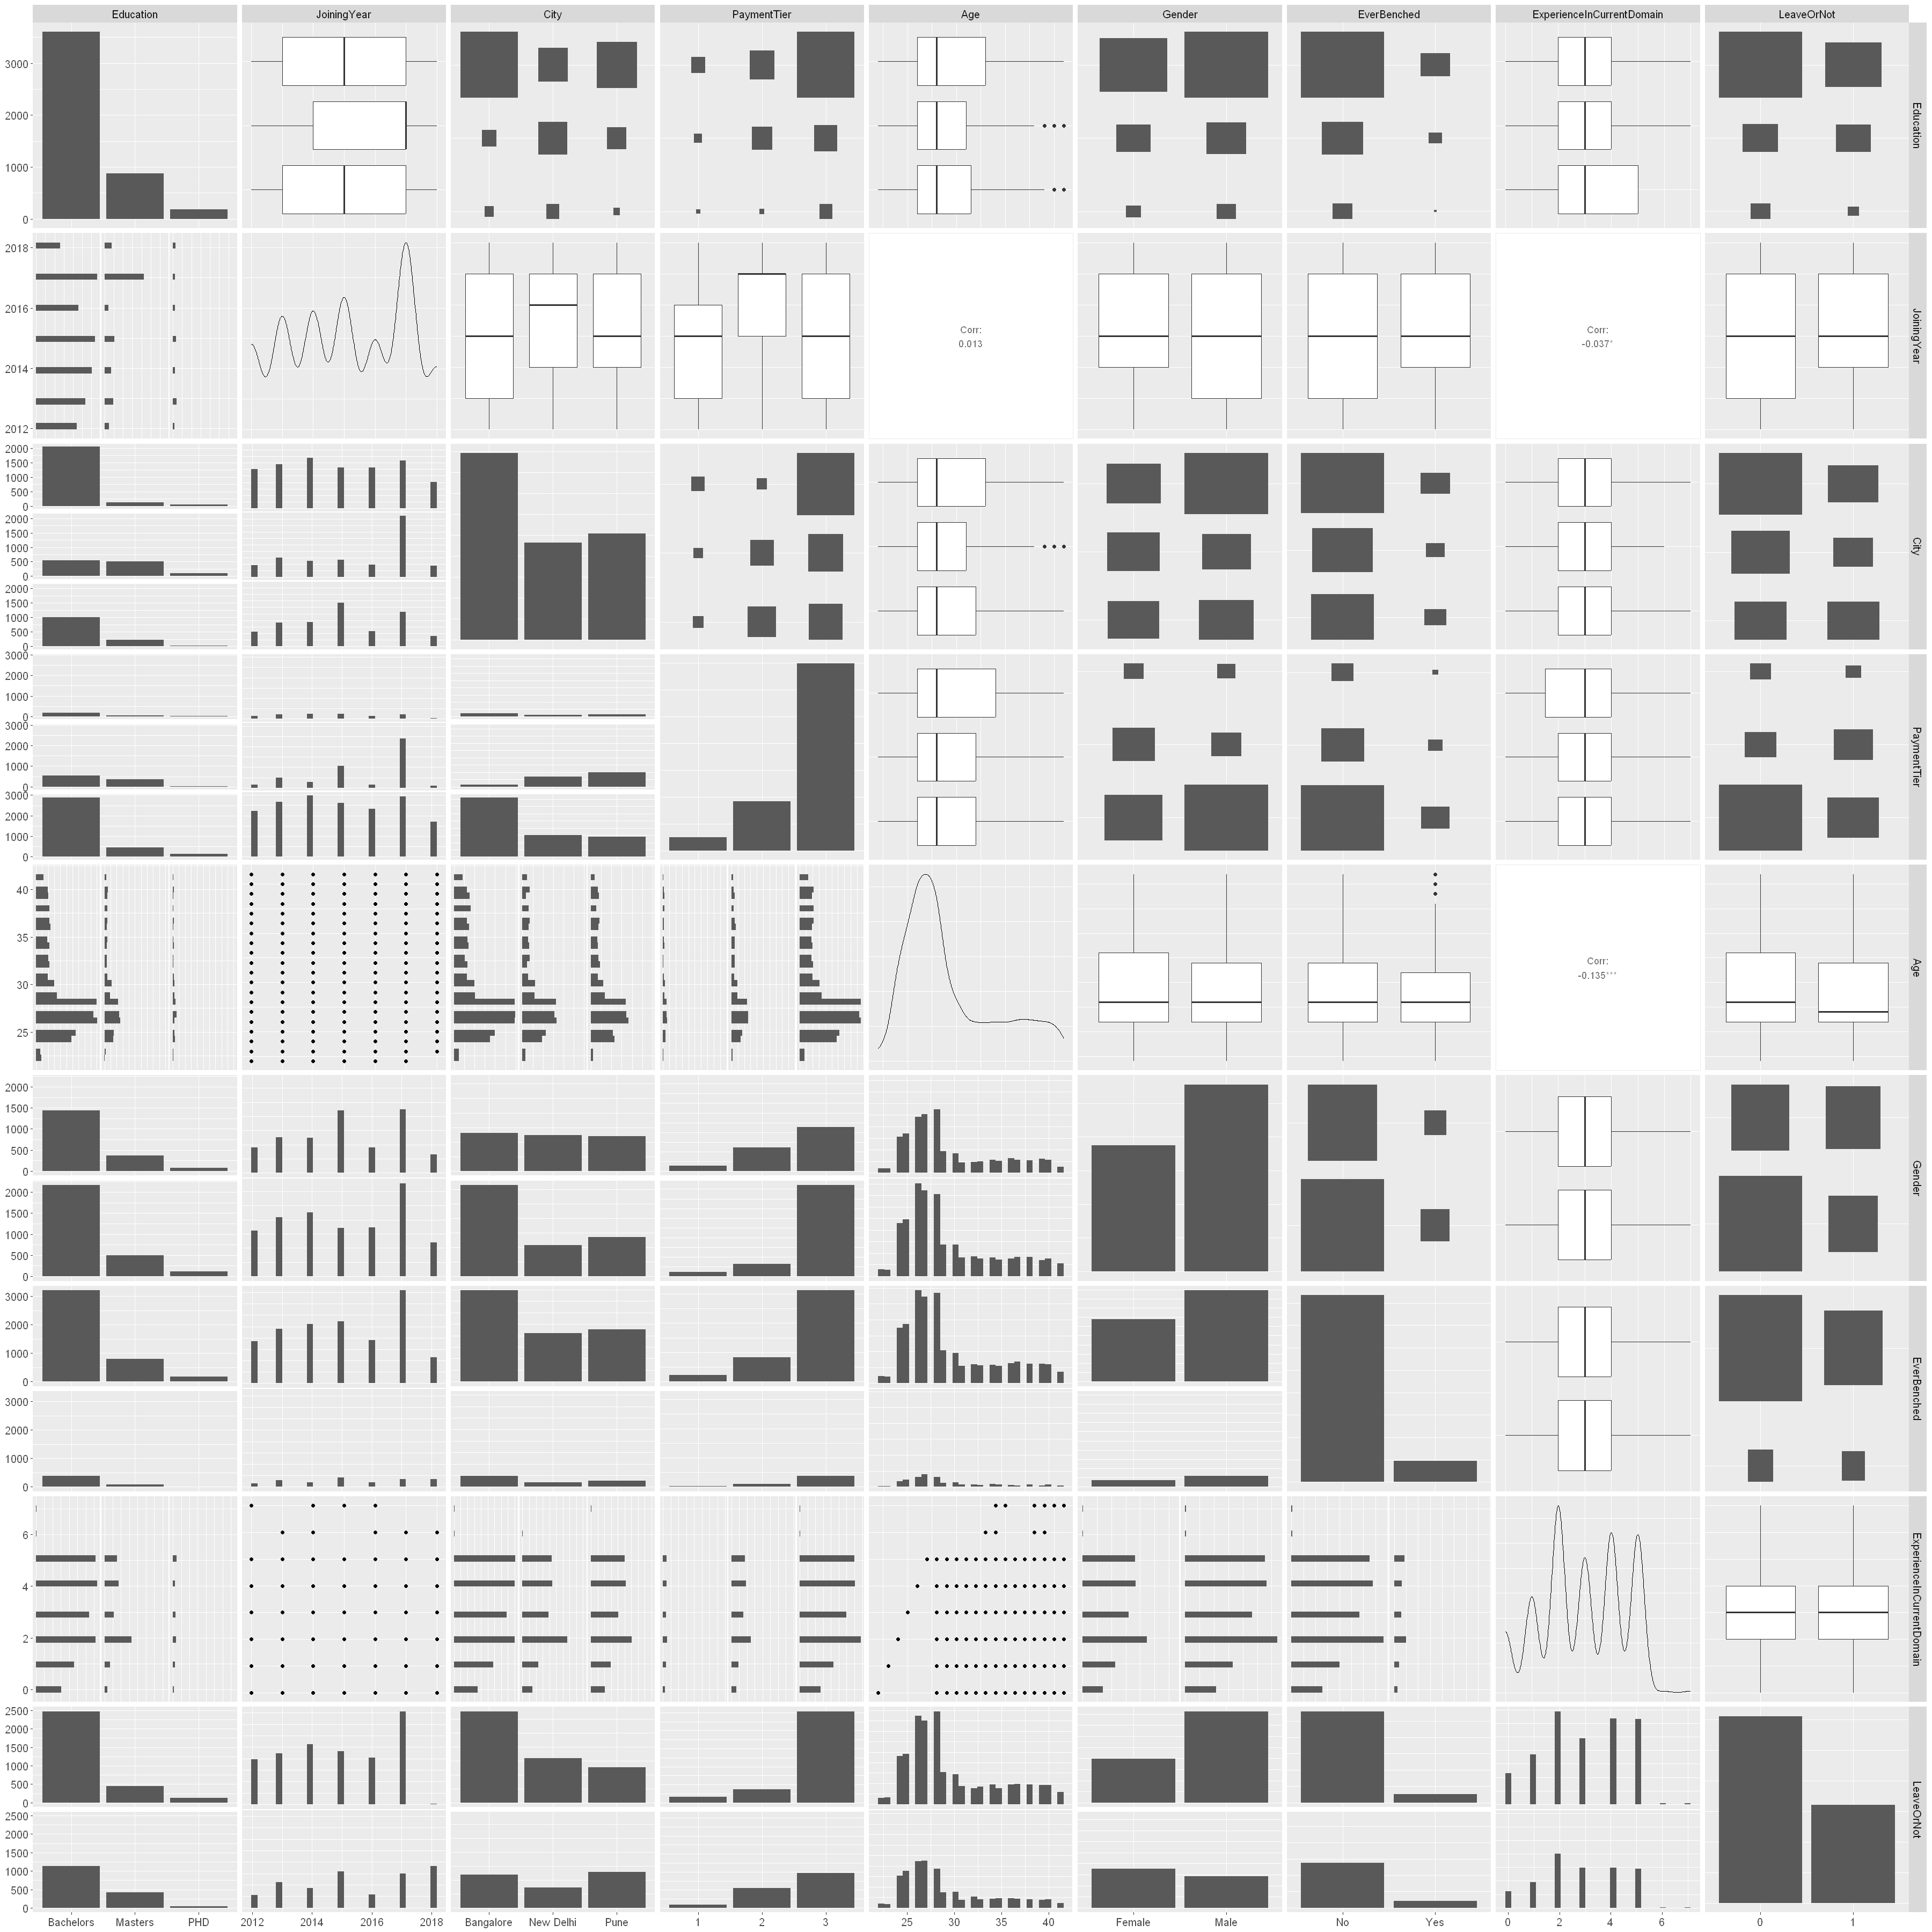

In [18]:
# Main Developer: Hiroshi
options(repr.plot.width = 30, repr.plot.height = 30)

Employee_pair_plot <- employee_data %>%
    ggpairs(progress = FALSE) +
    theme(
        text = element_text(size = 15),
        plot.title = element_text(face = "bold"),
        axis.title = element_text(face = "bold"))

Employee_pair_plot

- We can see from this that most of the variables seem to be somewhat right skewed
- We can see that education in particular has a strong skew, with one category much more common than others
- There seems to be a degree of correlation between the numerical columns, we might have to take a look at that later
- The categorical variables seem to be very unrelated to eachother.

Box plots between the categories and frequency.

In [ ]:
# Main Developer: Hiroshi

# Plot for numeric variables
p1 <- ggplot(Employee_long_num, aes(x = value, fill = factor(rep(employee_data$LeaveOrNot, length(unique(Employee_long_num$variable)))))) +
  facet_wrap(~ variable, scales = "free") +
  geom_histogram(position = "identity", binwidth = 1, alpha = 0.4) + 
  theme_minimal() +
  labs(title = "Distribution of Numeric Variables by Employee Retention",
       x = "Value",
       y = "Frequency") +  
  scale_fill_manual(values = c("0" = "lightblue", "1" = "orange"),
                    labels = c("Stayed", "Left"),
                    name = "Employee Status")

# Plot for categorical variables stays the same
p2 <- ggplot(Employee_long_cat, aes(x = value, fill = factor(rep(employee_data$LeaveOrNot, length(unique(Employee_long_cat$variable)))))) +
  facet_wrap(~ variable, scales = "free") +
  geom_bar(position = "dodge", alpha = 0.7) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Distribution of Categorical Variables by Employee Retention",
       x = "Category",
       y = "Frequency") +
  scale_fill_manual(values = c("0" = "lightblue", "1" = "orange"),
                    labels = c("Stayed", "Left"),
                    name = "Employee Status")

# Display plots
options(repr.plot.width = 12, repr.plot.height = 4)
p1
options(repr.plot.width = 12, repr.plot.height = 8)
p2

ERROR: Error: object 'Employee_long_cat' not found


Box plots between the categories and proportions.

In [ ]:
# Main Developer: Hiroshi
Employee_long_num$LeaveOrNot <- factor(rep(employee_data$LeaveOrNot, length(unique(Employee_long_num$variable))))

Employee_long_num_prop <- Employee_long_num %>%
  group_by(variable, value, LeaveOrNot) %>%
  tally() %>%
  group_by(variable, value) %>%
  mutate(proportion = n / sum(n))  

#numerical columns
p1 <- ggplot(Employee_long_num_prop, aes(x = value, y = proportion, fill = LeaveOrNot)) +
  facet_wrap(~ variable, scales = "free") +
  geom_bar(stat = "identity", position = "stack", alpha = 0.7) +  
  theme_minimal() +
  labs(title = "Proportion of Numeric Variables by Employee Retention",
       x = "Value",
       y = "Proportion") +
  scale_fill_manual(values = c("0" = "lightblue", "1" = "orange"),
                    labels = c("Stayed", "Left"),
                    name = "Employee Status")
#Categorical columns
p2 <- ggplot(Employee_long_cat, aes(x = value, fill = factor(rep(employee_data$LeaveOrNot, length(unique(Employee_long_cat$variable)))))) +
  facet_wrap(~ variable, scales = "free") +
  geom_bar(position = "fill", alpha = 0.7) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(title = "Proportion of Categorical Variables by Employee Retention",
       x = "Category",
       y = "Proportion") +
  scale_fill_manual(values = c("0" = "lightblue", "1" = "orange"),
                    labels = c("Stayed", "Left"),
                    name = "Employee Status")

options(repr.plot.width = 12, repr.plot.height = 4)
p1
options(repr.plot.width = 12, repr.plot.height = 8)
p2

ERROR: Error: object 'Employee_long_cat' not found


This time we can see clearly that all of the columns have some sort of pattern in whether or not an employee has stayed or left. The trends seem to be pretty obvious across the board, with the exception of Age and ExperienceInCurrentDomain which have a slightly weaker, but still visibly downwards trend as its value increases.

For the other columns, we can see that:
- A much higher proportion of masters graduates leave at ~48% compared to their Bachelors and PHD coutnerparts at ~30% and ~25% respectively.
- Pune has the highest proportion of leavers at ~50% followed by New Delhi and Bangalore at about ~30% and ~26% respectively.
- Female employees have a considerably higher proportion of leavers than their male counterparts (~48% vs ~25%)
- Those who have been benched have a considerably higher proportion of leaving than those who haven't (~45% vs ~30%)
- Payment tier 2 employees have the highest chance of leaving the company at ~60% followed by tier 1 and 2 at ~37% and ~27%
- An abnormally high proportion of employees who joined in 2018 have left the company, nearing 100%, followed by 2015, 2013 at ~40%, ~30%, followed by the rest at about 24%

We can now see whether there is any multicolinearity in our numerical columns that we have to pay attention to when deciding what model to use.

Correlation matrix

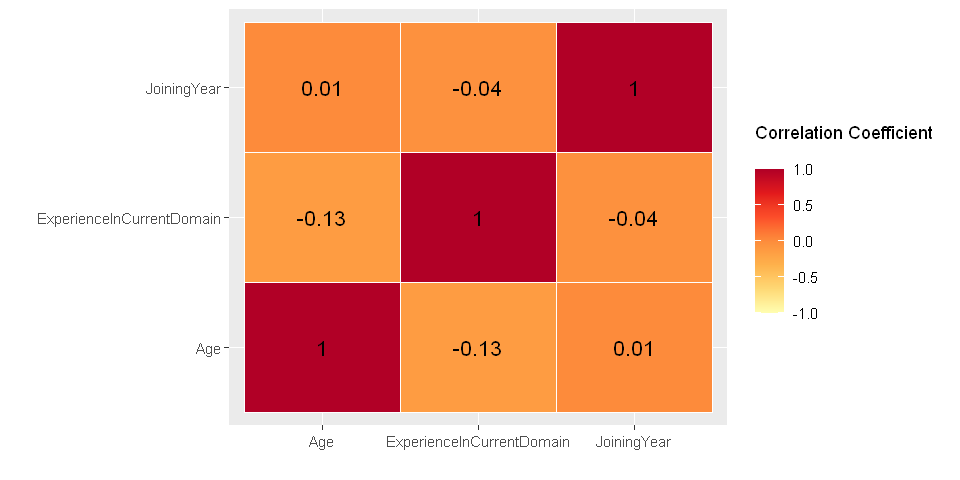

In [ ]:
# Main Developer: Hiroshi
Employee_num <- employee_data %>%
    dplyr::select(-LeaveOrNot, -Education, -City, -Gender, -EverBenched, -PaymentTier)

corr_matrix <- 
    Employee_num %>%
    cor() %>%
    as_tibble(rownames = 'var1') %>%
    pivot_longer(-var1, names_to = "var2", values_to = "corr")

plot_corr_matrix <- 
    corr_matrix %>%
    ggplot(aes(var1, var2)) +
    geom_tile(aes(fill = corr), color = "white") +
    scale_fill_distiller("Correlation Coefficient \n",
                         palette = "YlOrRd",
                         direction = 1, 
                         limits = c(-1, 1)
    ) +
    labs(x = "", y = "") +
    geom_text(aes(var2, var1, label = round(corr, 2)), color = "black", size = 4.5)

options(repr.plot.width = 8, repr.plot.height = 4)
plot_corr_matrix

We can see that there is no multicolinearity of note within our numerical columns, the most correlated variables that we can see are Age and ExperienceInCurrentDomain, however it is only -0.13, and that is negligible correlation that is unlikely to be representative of multicolinearity. However, we can keep this in mind when testing our model later.

## Methods: Plan

### Analysis Overview

The goal of this analysis is to predict employee attrition using a dataset of 4,653 records and nine variables. The target variable, LeaveOrNot, is binary, indicating whether an employee has left the company (1) or stayed (0). Predictor variables include demographic (e.g., age, gender), educational (e.g., degree level), and job-related factors (e.g., experience, payment tier, and benching status). Lasso regression, a machine learning technique for feature selection and regularization, was applied to identify significant predictors while balancing interpretability and predictive accuracy.

### Data Preparation

The dataset was split into 70% training and 30% testing subsets to ensure model generalizability. Splitting the data ensures that the model is trained on one portion and validated on unseen data for unbiased evaluation. This prevents model overfitting issues.

Predictor variables were encoded as necessary, with categorical variables (e.g., City, Gender) converted to dummy variables and ordinal variables (e.g., Payment Tier) treated appropriately. The training data was used to fit the Lasso regression model, while the test data was used to evaluate its performance.

In [33]:
# Main Developer: Samin
set.seed(123) # Set seed for reproducibility

trainIndex <- createDataPartition(employee_data$LeaveOrNot, p = 0.7, list = FALSE)
trainData <- employee_data[trainIndex, ]  # Training data (70%)
testData <- employee_data[-trainIndex, ] # Testing data (30%)

head(trainData)
nrow(trainData)

head(testData)
nrow(testData)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
,<fct>,<int>,<fct>,<ord>,<int>,<fct>,<fct>,<int>,<fct>
1,Bachelors,2017,Bangalore,3,34,Male,No,0,0
2,Bachelors,2013,Pune,1,28,Female,No,3,1
3,Bachelors,2014,New Delhi,3,38,Female,No,2,0
4,Masters,2016,Bangalore,3,27,Male,No,5,1
5,Masters,2017,Pune,3,24,Male,Yes,2,1
7,Bachelors,2015,New Delhi,3,38,Male,No,0,0


[1] 3258

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
,<fct>,<int>,<fct>,<ord>,<int>,<fct>,<fct>,<int>,<fct>
6,Bachelors,2016,Bangalore,3,22,Male,No,0,0
10,Masters,2017,New Delhi,2,37,Male,No,2,0
13,Bachelors,2018,Pune,3,32,Male,Yes,5,1
20,Bachelors,2016,New Delhi,2,22,Female,No,0,1
23,Bachelors,2017,New Delhi,2,36,Male,No,3,0
29,Bachelors,2013,Pune,2,31,Female,No,2,1


[1] 1395

### Feature Selection Process

Feature selection was performed using Lasso regression, which shrinks the coefficients of irrelevant predictors to zero, retaining only the most significant features. Predictors were transformed into a matrix format, ensuring the response variable was numeric for compatibility with logistic regression. Cross-validation was employed to determine the optimal regularization parameter (lambda) that minimizes prediction error. The glmnet package in R was used for this purpose.

In [ ]:
# Main Developer: Samin

# Convert predictors to matrix and response to numeric
X <- model.matrix(LeaveOrNot ~ ., data = trainData)[, -1]
y <- as.numeric(as.character(trainData$LeaveOrNot))

# Lasso regression
lasso_model <- cv.glmnet(X, y, alpha = 1, family = "binomial")
best_lambda_lasso <- lasso_model$lambda.min
best_lambda_lasso

[1] 0.00089525

Lasso regression not only enhances model performance by eliminating redundant predictors but also handles multicollinearity among variables effectively.

### Model Fitting and Assessment

The Lasso regression model was fitted to the training data using the optimal lambda value. Coefficients were extracted, and odds ratios were calculated for interpretability. These odds ratios indicate the relative likelihood of an employee leaving the company for each variable.

In [40]:
# Main Developer: Samin

# Coefficients for Lasso
lasso_coefficients <- coef(lasso_model, s = best_lambda_lasso)
lasso_coefficients

12 x 1 sparse Matrix of class "dgCMatrix"
                                     s1
(Intercept)               -340.34925344
EducationMasters             0.80424941
EducationPHD                 0.21781989
JoiningYear                  0.16920446
CityNew Delhi               -0.60323874
CityPune                     0.58943085
PaymentTier.L               -0.15908187
PaymentTier.Q               -0.51645967
Age                         -0.02587162
GenderMale                  -0.81336447
EverBenchedYes               0.66352604
ExperienceInCurrentDomain   -0.05978972

In [41]:
# Main Developer: Samin

# Odds Ratio
lasso_coefficients <- as.matrix(lasso_coefficients)
odds_ratios <- exp(lasso_coefficients)
odds_ratios

,s1
(Intercept),1.542401e-148
EducationMasters,2.235018e+00
EducationPHD,1.243363e+00
JoiningYear,1.184362e+00
CityNew Delhi,5.470371e-01
CityPune,1.802962e+00
PaymentTier.L,8.529265e-01
PaymentTier.Q,5.966291e-01
Age,9.744602e-01
GenderMale,4.433639e-01


### Performance Evaluation

The test data was used to predict the probability of attrition, and a classification threshold of 0.5 was applied to categorize predictions as staying (0) or leaving (1). Model performance was evaluated using key metrics such as accuracy, sensitivity, specificity, and the Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) curve.

In [42]:
# Main Developer: Samin

# Predictions on test data
X_test <- model.matrix(LeaveOrNot ~ ., data = testData)[, -1]
lasso_preds <- predict(lasso_model, s = best_lambda_lasso, newx = X_test, type = "response")
lasso_classes <- ifelse(lasso_preds > 0.5, 1, 0)

# Confusion matrix
conf_matrix <- confusionMatrix(as.factor(lasso_classes), testData$LeaveOrNot)
conf_matrix

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 825 281
         1  90 199
                                        
               Accuracy : 0.7341        
                 95% CI : (0.71, 0.7571)
    No Information Rate : 0.6559        
    P-Value [Acc > NIR] : 2.164e-10     
                                        
                  Kappa : 0.3493        
                                        
 Mcnemar's Test P-Value : < 2.2e-16     
                                        
            Sensitivity : 0.9016        
            Specificity : 0.4146        
         Pos Pred Value : 0.7459        
         Neg Pred Value : 0.6886        
             Prevalence : 0.6559        
         Detection Rate : 0.5914        
   Detection Prevalence : 0.7928        
      Balanced Accuracy : 0.6581        
                                        
       'Positive' Class : 0             
                                        

Setting levels: control = 0, case = 1

Warning message in roc.default(testData$LeaveOrNot, lasso_preds):
"Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector."
Setting direction: controls < cases



[1] "AUC: 0.744874772313297"


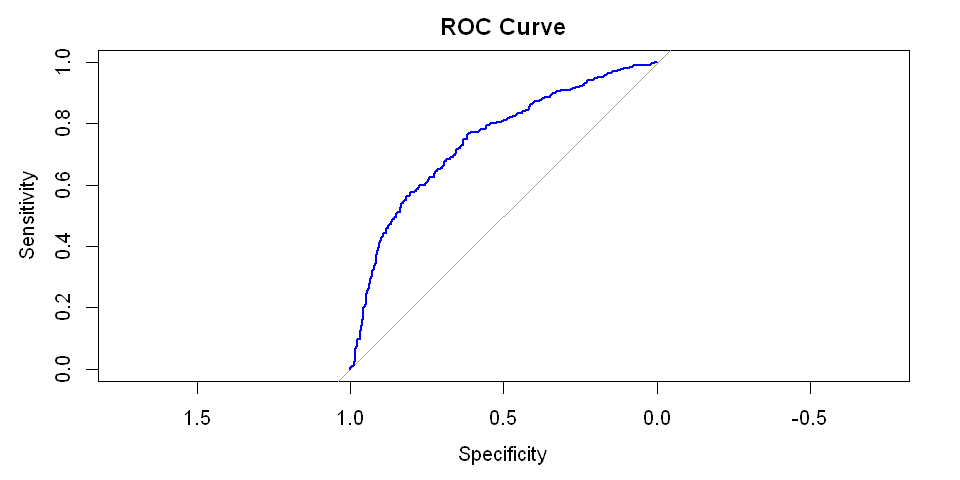

In [43]:
# Main Developer: Samin

# ROC curve and AUC
roc_curve <- roc(testData$LeaveOrNot, lasso_preds)
plot(roc_curve, col = "blue", main = "ROC Curve")
auc_value <- auc(roc_curve)
print(paste("AUC:", auc_value))

### Results Interpretation

The model achieved an accuracy of 73.41%, with high sensitivity (90.16%) for identifying employees who stay but lower specificity (41.46%) for predicting attrition. The AUC of 0.7448 indicates moderate discriminatory power. While the model effectively identifies key predictors, the low specificity suggests that further improvements, such as resampling techniques or threshold adjustments, may be required to better predict employees likely to leave.

## Discussion

## References

[1] Tibshirani, R. (1996). Regression Shrinkage and Selection via the Lasso. Journal of the Royal Statistical Society. Series B (Methodological), 58(1), 267–288. Retrieved from https://www.jstor.org/stable/2346178

[2] Elmetwally , T. (n.d.). Employee dataset. Retrieved from www.kaggle.com website: https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset

[3] Cortes, C., & Mohri, M. (2024). AUC Optimization vs. Error Rate Minimization. Advances in Neural Information Processing Systems, 16. Retrieved from https://papers.nips.cc/paper_files/paper/2003/hash/6ef80bb237adf4b6f77d0700e1255907-Abstract.html